In [1]:
import numpy as np
import time
import hashlib
import matplotlib.pyplot as plt

In [209]:
class StockExchange:    
    def __init__(self):
        self.epilson = 1e-2
        self.bid = []
        self.ask = []
        self.trades = []

    def notice(ident, cash, stock):
        print(ident, cash, stock)
        
    # buy as much stock as possible with cash
    def buy(self, ident, cash, limit=None):
        print("buy - ", ident, cash, limit)
        
        buyer_stock = 0
        updates = []
        
        while cash > 0.0 and len(self.ask) > 0:
            other_ident,price,size = self.ask.pop(0)
        
        
            if limit and price > limit:
                self.ask = [(other_ident,price,size)] + self.ask
                break
                
            target = cash/price
            target = min(target,size)

            size -= target
            cash -= target*price
            buyer_stock += target

            # rounding error fix - maybe i shouldnt use floats
            if cash < self.epilson:
                cash = 0.0

            # restore book
            if size > 0:
                self.ask = [(other_ident, price, size)] + self.ask

            updates.append((other_ident, target*price, 0))
            self.trades.append((price, target))
            
        updates.append((ident, cash, buyer_stock))
        return updates
            
    # sell as much stock as possible for best value
    def sell(self, ident, seller_stock, limit=None):
        print("sell - ", ident, seller_stock, limit)
        seller_cash = 0.0
        updates = []
        
        while seller_stock > 0.0 and len(self.bid) > 0:
            other_ident,price,size = self.bid.pop(0)
        
            if limit and price < limit:
                self.bid = [(other_ident,price,size)] + self.bid
                break

            target = min(seller_stock,size)
            
            size -= target

            seller_cash  += target*price
            seller_stock -= target
            
            # rounding error fix - maybe i shouldnt use floats
            if seller_stock < self.epilson:
                seller_stock = 0.0
            
            # restore book
            if size > 0.0:
                self.bid = [(other_ident, price, size)] + self.bid
                        
            updates.append((other_ident, 0, target))
            self.trades.append((price, target))
            
        updates.append((ident, seller_cash, seller_stock))
        return updates
        
    def cancel(self, ident):
        print("cancel - ", ident)
        updates = []
        
        idx = []
        for i in range(len(self.ask)):
            if self.ask[i][0] == ident:
                idx.append(i)

        idx.reverse()
        for i in idx:
            updates += [self.ask.pop(i)] 
    
        idx = []
        for i in range(len(self.bid)):
            if self.bid[i][0] == ident:
                idx.append(i)
        
        idx.reverse()
        for i in idx:
            updates += [self.bid.pop(i)] 
            
        return updates

    def insert_bid(self, ident, price, size):
        print("bid order", ident,price,size)
        
        for i in range(len(self.bid)):
            if self.bid[i][1] < price:
                self.bid.insert(i, (ident,price,size))
                return
        
        self.bid.insert(len(self.bid), (ident,price,size))

    def insert_ask(self, ident, price, size):
        print("ask order", ident,price,size)
        
        for i in range(len(self.ask)):
            if self.ask[i][1] > price:
                self.ask.insert(i, (ident,price,size))
                return
        
        self.ask.insert(len(self.ask), (ident,price,size))
            
    # public api here
    def buy_limit(self, ident, cash, limit=None):
        updates = self.buy(ident, cash, limit)
        
        if limit is not None:
            # if there was cash left then make the book entry 
            if updates[-1][1] > 0.0:
                # take the last update which is always the final state of the buyer
                ident, cash, stock = updates.pop(-1)
            
                self.insert_bid(ident, limit, cash/limit)
                updates.append((ident,0,stock))   

        for i,p,s in updates:
            print(" + updates ", i,p,s)

    def sell_limit(self, ident, seller_stock, limit=None):
        updates = self.sell(ident, seller_stock, limit)
        
        if limit is not None:
            # if there was stock left then make the book entry 
            if updates[-1][2] > 0:
                # take the last update which is always the final state of the buyer
                ident, cash, stock = updates.pop(-1)
                
                self.insert_ask(ident, limit, stock)
                updates.append((ident,cash,0))                
                
        for i,p,s in updates:
            print(" + updates ", i,p,s)
    
    def order_cancel(self, ident):
        updates = self.cancel(ident)
        
        for i,p,s in updates:
            print(" + updates ", i,p,s)        
        
    def last_price(self):
        if self.trades:
            last_price, _ = self.trades[-1]
        else:
            last_price = 100.0
            
        return last_price

In [270]:
s = StockExchange()

In [271]:
s.sell_limit("a", 100, limit=100)
s.order_cancel("a")
s.sell_limit("b", 100, limit=102)
s.sell_limit("c", 100, limit=104)
s.buy_limit("d", 150*101, limit=101)
s.buy_limit("e", 150*102, limit=102)

sell -  a 100 100
ask order a 100 100
 + updates  a 0.0 0
cancel -  a
 + updates  a 100 100
sell -  b 100 102
ask order b 102 100
 + updates  b 0.0 0
sell -  c 100 104
ask order c 104 100
 + updates  c 0.0 0
buy -  d 15150 101
bid order d 101 150.0
 + updates  d 0 0
buy -  e 15300 102
bid order e 102 50.0
 + updates  b 10200 0
 + updates  e 0 100


In [272]:
s.ask

[('c', 104, 100)]

In [273]:
s.bid

[('e', 102, 50.0), ('d', 101, 150.0)]

In [274]:
s.trades

[(102, 100)]

In [275]:
s.last_price()

102

In [225]:
class RandomAgent:
    def __init__(self):
        self.name = hashlib.sha224(str(time.time()).encode()).hexdigest()[:6]
    
    def act(self, stock):
        last = s.last_price()
        predict = last * (1.0 + 0.1*np.random.normal())
        
        size = np.random.uniform(1000)
                
        stock.order_cancel(self.name)
        if last < predict:
            stock.buy_limit(self.name, size*predict, limit=predict)
        else:
            stock.sell_limit(self.name, size, limit=predict)

In [239]:
agents = [RandomAgent() for i in range(30)]
stock = StockExchange()

In [240]:
for i in range(300):
    for a in agents:
        a.act(stock)

cancel -  3c9e95
sell -  3c9e95 778.7381397090728 95.88138047676522
ask order 3c9e95 95.88138047676522 778.7381397090728
 + updates  3c9e95 0.0 0
cancel -  f64a30
buy -  f64a30 41744.76672809948 105.80968527687003
 + updates  3c9e95 41744.76672809948 0
 + updates  f64a30 0.0 435.3792834492555
cancel -  d9920b
sell -  d9920b 707.2619062324553 88.57401599903767
ask order d9920b 88.57401599903767 707.2619062324553
 + updates  d9920b 0.0 0
cancel -  4045f1
buy -  4045f1 19296.447103303046 102.63991226645307
 + updates  d9920b 19296.447103303046 0
 + updates  4045f1 0.0 217.85674823091117
cancel -  4b8327
buy -  4b8327 46730.807305286115 102.62051075222237
 + updates  d9920b 43348.58029484033 0
 + updates  3c9e95 3382.227010445786 0
 + updates  4b8327 0.0 524.6802760028478
cancel -  203cd2
buy -  203cd2 37072.29790419558 104.9128677028443
bid order 203cd2 104.9128677028443 71.80057072563143
 + updates  3c9e95 29539.49412666869 0
 + updates  203cd2 0 308.0837382585136
cancel -  1e1892
buy - 

 + updates  c12d8e 0 151.90654857609297
 + updates  d9920b 81221.08311607083 0.0
cancel -  4045f1
sell -  4045f1 861.8380806036189 84.24451784800742
 + updates  c12d8e 0 384.9996336026344
 + updates  2a149e 0 369.79166145512863
 + updates  4b8327 0 107.04678554585587
 + updates  4045f1 89375.44738966477 0.0
cancel -  4b8327
 + updates  4b8327 103.23366679929596 361.01780656658
buy -  4b8327 71714.50696753929 117.44807119658613
bid order 4b8327 117.44807119658613 610.6060851991567
 + updates  4b8327 0 0
cancel -  203cd2
sell -  203cd2 427.6486268297133 99.3786582274896
 + updates  4b8327 0 427.6486268297133
 + updates  203cd2 50226.50637101846 0.0
cancel -  1e1892
sell -  1e1892 625.4863575879642 100.00874218478602
 + updates  4b8327 0 182.95745836944343
 + updates  872594 0 442.5288992185208
 + updates  1e1892 67082.70294591019 0.0
cancel -  e21eb6
sell -  e21eb6 951.0907957181346 91.11502545114718
ask order e21eb6 91.11502545114718 304.0220458160064
 + updates  872594 0 255.7395096066

 + updates  8e697a 0 423.6256951336384
 + updates  19c6d1 48760.16563895727 0.0
cancel -  2a149e
buy -  2a149e 76016.67419904195 109.47804008758645
bid order 2a149e 109.47804008758645 694.355453735067
 + updates  2a149e 0 0
cancel -  41a64e
sell -  41a64e 377.2394342963521 88.49973797458694
 + updates  8e697a 0 198.42675173366763
 + updates  fb68db 0 178.81268256268447
 + updates  41a64e 42744.70383145477 0.0
cancel -  c12d8e
sell -  c12d8e 209.8662301398656 96.73507257033945
 + updates  fb68db 0 101.44665414449219
 + updates  2a149e 0 108.4195759953734
 + updates  c12d8e 23162.58131715761 0.0
cancel -  bba30c
sell -  bba30c 60.4560046373515 81.2795027608843
 + updates  2a149e 0 60.4560046373515
 + updates  bba30c 6618.60489922328 0.0
cancel -  8c8677
sell -  8c8677 700.1095437322571 98.19111715938013
 + updates  2a149e 0 525.4798731023421
 + updates  576079 0 174.62967062991493
 + updates  8c8677 75546.45137732157 0.0
cancel -  3c9e95
sell -  3c9e95 173.83429473142974 97.2726978276181

 + updates  6775e8 0 0
cancel -  872594
buy -  872594 28722.69050584459 113.44096067889588
bid order 872594 113.44096067889588 253.1950570054371
 + updates  872594 0 0
cancel -  193777
 + updates  193777 104.89511217425547 23.400497828799757
sell -  193777 894.550055150012 74.62717639220769
 + updates  1e1892 0 137.6511508829218
 + updates  872594 0 253.1950570054371
 + updates  6775e8 0 503.7038472616531
 + updates  193777 101610.22381455638 0.0
cancel -  8e697a
buy -  8e697a 88978.87875777548 115.38707864599829
bid order 8e697a 115.38707864599829 771.1338201979979
 + updates  8e697a 0 0
cancel -  fb68db
sell -  fb68db 995.7662578994602 97.58584935462639
 + updates  8e697a 0 771.1338201979979
 + updates  6775e8 0 89.29064622605665
 + updates  bba30c 0 135.34179147540567
 + updates  fb68db 113450.86541522248 0.0
cancel -  576079
sell -  576079 471.8934591225901 99.90297498057014
 + updates  bba30c 0 471.8934591225901
 + updates  576079 50018.246279875864 0.0
cancel -  19c6d1
buy -  19c

sell -  19c6d1 142.04191163417545 95.31642706419348
 + updates  9a8558 0 3.7827487948222824
 + updates  6775e8 0 138.25916283935317
 + updates  19c6d1 16149.68697900002 0.0
cancel -  2a149e
buy -  2a149e 101405.47047524631 114.50162564663985
bid order 2a149e 114.50162564663985 885.6247228156462
 + updates  2a149e 0 0
cancel -  41a64e
 + updates  41a64e 102.7371237528838 886.9811393748523
sell -  41a64e 138.01414551500704 86.05003850135951
 + updates  2a149e 0 138.01414551500704
 + updates  41a64e 15802.844023700214 0.0
cancel -  c12d8e
 + updates  c12d8e 103.44568025332659 219.38056519780923
buy -  c12d8e 5637.551023795484 112.0473721398655
bid order c12d8e 112.0473721398655 50.31399591199954
 + updates  c12d8e 0 0
cancel -  bba30c
sell -  bba30c 799.8960173597625 88.54748792540828
 + updates  2a149e 0 747.6105773006392
 + updates  6775e8 0 52.28544005912329
 + updates  bba30c 91537.41619612352 0.0
cancel -  8c8677
 + updates  8c8677 106.85350593966861 163.77675739200276
buy -  8c8677 

 + updates  c12d8e 0.0 0
cancel -  bba30c
sell -  bba30c 776.1979366320519 83.75439892291503
ask order bba30c 83.75439892291503 776.1979366320519
 + updates  bba30c 0.0 0
cancel -  8c8677
buy -  8c8677 60446.135681880776 112.43311840532098
 + updates  bba30c 60446.135681880776 0
 + updates  8c8677 0.0 721.7069963992403
cancel -  3c9e95
sell -  3c9e95 19.40298217462214 98.61597474801492
ask order 3c9e95 98.61597474801492 19.40298217462214
 + updates  3c9e95 0.0 0
cancel -  f64a30
sell -  f64a30 281.3722142298151 74.94132273446759
ask order f64a30 74.94132273446759 281.3722142298151
 + updates  f64a30 0.0 0
cancel -  d9920b
buy -  d9920b 107218.20170793611 112.14822728648458
 + updates  f64a30 21086.405915108327 0
 + updates  bba30c 4563.85594594362 0
 + updates  576079 7243.590160159825 0
 + updates  3c9e95 1913.4440001687205 0
 + updates  fb68db 72410.90568655562 0
 + updates  d9920b 0.0 1159.822014783259
cancel -  4045f1
buy -  4045f1 78635.25892405228 133.76995680856956
 + updates  f

 + updates  3c9e95 34855.67200089185 0.0
cancel -  f64a30
buy -  f64a30 106048.53061764926 115.9937695361637
bid order f64a30 115.9937695361637 914.2605765957646
 + updates  f64a30 0 0
cancel -  d9920b
buy -  d9920b 12513.272085434044 109.7752956987585
bid order d9920b 109.7752956987585 113.98987363944366
 + updates  d9920b 0 0
cancel -  4045f1
sell -  4045f1 483.73249282598454 86.73568067926475
 + updates  f64a30 0 483.73249282598454
 + updates  4045f1 56109.95529001121 0.0
cancel -  4b8327
sell -  4b8327 532.4212820438756 98.25347281835441
 + updates  f64a30 0 430.5280837697801
 + updates  d9920b 0 101.89319827409554
 + updates  4b8327 61123.931297869116 0.0
cancel -  203cd2
sell -  203cd2 263.24177032027444 98.91202119911779
 + updates  d9920b 0 12.09667536534812
 + updates  8c8677 0 251.14509495492632
 + updates  203cd2 28528.616600719914 0.0
cancel -  1e1892
sell -  1e1892 533.5486622571967 95.25016661943518
ask order 1e1892 95.25016661943518 369.520952956944
 + updates  8c8677 0 

sell -  872594 244.1226661474567 87.87239031680996
 + updates  460853 0 76.38926849850998
 + updates  4b9716 0 167.73339764894672
 + updates  872594 26867.535374877938 0.0
cancel -  193777
buy -  193777 98044.28527073875 120.59048554866906
bid order 193777 120.59048554866906 813.0349987783165
 + updates  193777 0 0
cancel -  8e697a
buy -  8e697a 22697.447995554438 108.05623025465194
bid order 8e697a 108.05623025465194 210.05219173447233
 + updates  8e697a 0 0
cancel -  fb68db
buy -  fb68db 34765.348220945 108.74565401267445
bid order fb68db 108.74565401267445 319.6941389206511
 + updates  fb68db 0 0
cancel -  576079
buy -  576079 40960.34485119419 111.66419169684562
bid order 576079 111.66419169684562 366.8171884716313
 + updates  576079 0 0
cancel -  19c6d1
buy -  19c6d1 77368.79787177852 104.43734771812665
bid order 19c6d1 104.43734771812665 740.8154224731429
 + updates  19c6d1 0 0
cancel -  2a149e
sell -  2a149e 134.07181282755857 90.44273955311753
 + updates  193777 0 134.071812827

 + updates  fb68db 14509.156157548285 0
 + updates  e21eb6 0.0 1044.7208712506122
cancel -  484fb6
sell -  484fb6 364.42469946885626 90.39623787530886
ask order 484fb6 90.39623787530886 364.42469946885626
 + updates  484fb6 0.0 0
cancel -  a47924
sell -  a47924 872.041004146715 100.55977392264688
ask order a47924 100.55977392264688 872.041004146715
 + updates  a47924 0.0 0
cancel -  56318f
buy -  56318f 105490.76650744524 109.47249705737062
 + updates  484fb6 32942.62182082467 0
 + updates  fb68db 31937.466521172308 0
 + updates  a47924 40610.67816544826 0
 + updates  56318f 0.0 1091.2616787948168
cancel -  c563fe
sell -  c563fe 171.1258363092519 88.61263534984428
ask order c563fe 88.61263534984428 171.1258363092519
 + updates  c563fe 0.0 0
cancel -  119656
buy -  119656 56332.61586663478 106.99040082146395
 + updates  c563fe 15163.91133180888 0
 + updates  a47924 41168.7045348259 0
 + updates  119656 0.0 580.5211932090585
cancel -  a54832
sell -  a54832 905.7313260153097 98.9480251601

bid order a47924 115.22479734711723 701.352902001874
 + updates  a47924 0 0
cancel -  56318f
buy -  56318f 2557.5515883219746 113.49299874211766
bid order 56318f 113.49299874211766 22.53488423663316
 + updates  56318f 0 0
cancel -  c563fe
buy -  c563fe 22653.41198064928 117.59732956320869
bid order c563fe 117.59732956320869 192.63542858320648
 + updates  c563fe 0 0
cancel -  119656
sell -  119656 89.02381593135078 101.91520759492134
 + updates  484fb6 0 89.02381593135078
 + updates  119656 10507.495208255832 0.0
cancel -  a54832
sell -  a54832 805.7995094392196 97.35218853589666
 + updates  484fb6 0 412.6247725530653
 + updates  c563fe 0 192.63542858320648
 + updates  a47924 0 200.5393083029478
 + updates  a54832 94462.68092565457 0.0
cancel -  4b9716
sell -  4b9716 574.9116945942369 93.46032852836055
ask order 4b9716 93.46032852836055 51.56321665867756
 + updates  a47924 0 500.8135936989262
 + updates  56318f 0 22.53488423663316
 + updates  4b9716 60263.696430962256 0
cancel -  1ed584

ask order a54832 98.50570163716601 198.51142834060533
 + updates  119656 0 685.2162180447903
 + updates  a54832 74330.97242633744 0
cancel -  4b9716
sell -  4b9716 957.0440774823254 90.06106683126879
ask order 4b9716 90.06106683126879 957.0440774823254
 + updates  4b9716 0.0 0
cancel -  1ed584
sell -  1ed584 390.9038976543062 89.68803976080406
ask order 1ed584 89.68803976080406 390.9038976543062
 + updates  1ed584 0.0 0
cancel -  460853
buy -  460853 95145.46603410546 126.66035234788151
 + updates  1ed584 35059.4043154727 0
 + updates  4b9716 60086.061718632765 0
 + updates  460853 0.0 1058.0741170700412
cancel -  9a8558
sell -  9a8558 377.5851885653203 92.05202510817504
ask order 9a8558 92.05202510817504 377.5851885653203
 + updates  9a8558 0.0 0
cancel -  6775e8
sell -  6775e8 803.0236995512507 95.30889442373994
ask order 6775e8 95.30889442373994 803.0236995512507
 + updates  6775e8 0.0 0
cancel -  872594
sell -  872594 452.1174287499939 99.69279920829993
ask order 872594 99.69279920

cancel -  872594
sell -  872594 770.590149179643 99.03359952980468
ask order 872594 99.03359952980468 770.590149179643
 + updates  872594 0.0 0
cancel -  193777
buy -  193777 46949.85484756107 102.37251002461166
 + updates  9a8558 46949.85484756107 0
 + updates  193777 0.0 488.7774632651542
cancel -  8e697a
buy -  8e697a 17157.08208424343 112.8648123754502
 + updates  9a8558 17157.08208424343 0
 + updates  8e697a 0.0 178.61599541460902
cancel -  fb68db
sell -  fb68db 367.7627298892139 81.65048818659531
ask order fb68db 81.65048818659531 367.7627298892139
 + updates  fb68db 0.0 0
cancel -  576079
buy -  576079 22601.946911916202 112.01166662534314
 + updates  fb68db 22601.946911916206 0
 + updates  576079 0.0 276.8133714064774
cancel -  19c6d1
sell -  19c6d1 236.000028950235 98.16775619419951
ask order 19c6d1 98.16775619419951 236.000028950235
 + updates  19c6d1 0.0 0
cancel -  2a149e
buy -  2a149e 5133.683383199822 114.32346282936943
 + updates  fb68db 5133.683383199822 0
 + updates  2

sell -  576079 5.312547422991543 90.88767720322174
 + updates  193777 0 5.312547422991543
 + updates  576079 648.3926563500839 0.0
cancel -  19c6d1
sell -  19c6d1 493.6376711517742 92.78878682519694
 + updates  193777 0 33.91187460339768
 + updates  fb68db 0 459.72579654837654
 + updates  19c6d1 55006.60257636332 0.0
cancel -  2a149e
sell -  2a149e 964.4844583690807 88.56928544935816
ask order 2a149e 88.56928544935816 15.463508732532034
 + updates  fb68db 0 233.56209600794324
 + updates  8e697a 0 415.7754535324545
 + updates  119656 0 299.6834000961509
 + updates  2a149e 101270.1514639278 0
cancel -  41a64e
buy -  41a64e 36298.0708162294 102.97150966560893
bid order 41a64e 102.97150966560893 339.2052715423552
 + updates  2a149e 1369.5919189802723 0
 + updates  41a64e 0 15.463508732532034
cancel -  c12d8e
buy -  c12d8e 40897.190966147995 110.25337200330645
bid order c12d8e 110.25337200330645 370.9382327546545
 + updates  c12d8e 0 0
cancel -  bba30c
sell -  bba30c 500.4638990684162 100.4

ask order 41a64e 90.49786863691091 608.5701128282369
 + updates  2a149e 0 13.926039063776011
 + updates  41a64e 1572.4261828959716 0
cancel -  c12d8e
sell -  c12d8e 347.3532878279914 99.55585067580613
ask order c12d8e 99.55585067580613 347.3532878279914
 + updates  c12d8e 0.0 0
cancel -  bba30c
sell -  bba30c 253.88560784970537 91.87423140657242
ask order bba30c 91.87423140657242 253.88560784970537
 + updates  bba30c 0.0 0
cancel -  8c8677
sell -  8c8677 513.0903905626765 98.80319821390943
ask order 8c8677 98.80319821390943 513.0903905626765
 + updates  8c8677 0.0 0
cancel -  3c9e95
buy -  3c9e95 92735.04656398295 104.1458832507581
 + updates  41a64e 55074.298127079834 0
 + updates  bba30c 23325.54508638213 0
 + updates  8c8677 14335.203350520986 0
 + updates  3c9e95 0.0 1007.5441754006852
cancel -  f64a30
sell -  f64a30 474.73374735075095 91.15106622750984
ask order f64a30 91.15106622750984 474.73374735075095
 + updates  f64a30 0.0 0
cancel -  d9920b
sell -  d9920b 881.6508179036371 9

cancel -  56318f
 + updates  56318f 106.45683871267794 773.4515297530808
sell -  56318f 297.52437806612363 86.9428979559329
 + updates  41a64e 0 272.3125817520447
 + updates  f64a30 0 25.211796314078924
 + updates  56318f 32884.79613490985 0.0
cancel -  c563fe
sell -  c563fe 419.45263226120255 93.63905119322109
 + updates  f64a30 0 118.05538668976794
 + updates  19c6d1 0 301.3972455714346
 + updates  c563fe 45810.98360323303 0.0
cancel -  119656
sell -  119656 187.55052442561043 101.00180984867052
 + updates  19c6d1 0 187.55052442561043
 + updates  119656 20442.2706744162 0.0
cancel -  a54832
buy -  a54832 57753.59292031965 104.10862446637144
bid order a54832 104.10862446637144 554.7435980097391
 + updates  a54832 0 0
cancel -  4b9716
sell -  4b9716 393.8121567794427 98.13569178888056
 + updates  19c6d1 0 97.77924928808409
 + updates  576079 0 296.0329074913586
 + updates  4b9716 42885.819148821785 0.0
cancel -  1ed584
 + updates  1ed584 104.01576062451863 155.69502207598316
sell -  1e

sell -  484fb6 475.3591853659615 81.6863244810551
 + updates  1e1892 0 475.3591853659615
 + updates  484fb6 54415.50537801973 0.0
cancel -  a47924
buy -  a47924 106410.22352207726 107.55237406343582
bid order a47924 107.55237406343582 989.3805176193981
 + updates  a47924 0 0
cancel -  56318f
buy -  56318f 31115.531715410492 117.41165815578528
bid order 56318f 117.41165815578528 265.0122841645374
 + updates  56318f 0 0
cancel -  c563fe
 + updates  c563fe 108.23200761025058 595.5784294270888
sell -  c563fe 317.61115871872676 77.37279425745425
 + updates  56318f 0 265.0122841645374
 + updates  1e1892 0 52.598874554189365
 + updates  c563fe 37136.65096437962 0.0
cancel -  119656
sell -  119656 518.2606080956516 95.98318342790961
 + updates  1e1892 0 139.44126998470733
 + updates  a47924 0 378.8193381109443
 + updates  119656 56705.09556885351 0.0
cancel -  a54832
sell -  a54832 866.9133731004858 93.04840063632531
 + updates  a47924 0 610.5611795084538
 + updates  e21eb6 0 16.04918752110006

 + updates  c563fe 55965.33998086125 0.0
cancel -  119656
sell -  119656 877.8881648810432 99.00278477424354
 + updates  a47924 0 11.536967161173152
 + updates  203cd2 0 51.49684734306629
 + updates  56318f 0 814.8543503768037
 + updates  119656 90283.86756032934 0.0
cancel -  a54832
buy -  a54832 89615.82529845115 104.95459130363423
bid order a54832 104.95459130363423 853.8533110875736
 + updates  a54832 0 0
cancel -  4b9716
sell -  4b9716 681.8435532669134 88.28471767542224
 + updates  a54832 0 681.8435532669134
 + updates  4b9716 71562.61146614666 0.0
cancel -  1ed584
buy -  1ed584 37147.12682549193 119.28450139303968
bid order 1ed584 119.28450139303968 311.4162057239356
 + updates  1ed584 0 0
cancel -  460853
buy -  460853 70124.76665285414 111.67112713232687
bid order 460853 111.67112713232687 627.9579015062545
 + updates  460853 0 0
cancel -  9a8558
sell -  9a8558 531.4556936042488 86.4366760703393
 + updates  1ed584 0 311.4162057239356
 + updates  460853 0 220.03948788031323
 + 

cancel -  bba30c
sell -  bba30c 821.6344819622806 91.93875300487562
 + updates  41a64e 0 739.0197771720271
 + updates  c12d8e 0 82.61470479025343
 + updates  bba30c 89480.93215678804 0.0
cancel -  8c8677
sell -  8c8677 873.2930918478714 98.39951111150951
 + updates  c12d8e 0 858.4904730980297
 + updates  4b9716 0 11.151826890766529
 + updates  2a149e 0 3.650791859075184
 + updates  8c8677 93947.42224019278 0.0
cancel -  3c9e95
sell -  3c9e95 25.83592570979806 84.6155379213328
 + updates  2a149e 0 25.83592570979806
 + updates  3c9e95 2751.7086878385953 0.0
cancel -  f64a30
sell -  f64a30 215.59037047369634 86.31984778840719
 + updates  2a149e 0 215.59037047369634
 + updates  f64a30 22961.898176608764 0.0
cancel -  d9920b
buy -  d9920b 19684.59000106078 108.85990479572637
bid order d9920b 108.85990479572637 180.8249790223366
 + updates  d9920b 0 0
cancel -  4045f1
sell -  4045f1 982.1551215484183 88.91699123116011
 + updates  d9920b 0 180.8249790223366
 + updates  2a149e 0 660.7516157569

cancel -  872594
sell -  872594 287.55963374033695 101.49220965315672
 + updates  119656 0 287.55963374033695
 + updates  872594 30688.23891767288 0.0
cancel -  193777
sell -  193777 382.4258933875069 100.35476187567255
 + updates  119656 0 204.49276146314992
 + updates  3c9e95 0 176.6905527455554
 + updates  c563fe 0 1.2425791788015772
 + updates  193777 40740.95541913546 0.0
cancel -  8e697a
sell -  8e697a 798.7439828277986 98.61258306424432
 + updates  c563fe 0 539.9789461491605
 + updates  fb68db 0 258.7650366786381
 + updates  8e697a 83988.58522119658 0.0
cancel -  fb68db
 + updates  fb68db 104.85087703739264 354.90324017969226
sell -  fb68db 567.2919088191652 92.95393511728868
 + updates  d9920b 0 567.2919088191652
 + updates  fb68db 59409.453138040604 0.0
cancel -  576079
 + updates  576079 102.83597468900582 525.5923638839963
buy -  576079 108255.85662039566 111.2327817341097
bid order 576079 111.2327817341097 973.2369804359469
 + updates  576079 0 0
cancel -  19c6d1
buy -  19c

 + updates  19c6d1 96.79100071817778 607.5609436336208
buy -  19c6d1 56262.37615231622 119.92729293242837
 + updates  193777 50885.2090779815 0
 + updates  fb68db 5377.16707433472 0
 + updates  19c6d1 0.0 599.6743930435584
cancel -  2a149e
buy -  2a149e 104853.23629782275 109.45203188988428
 + updates  fb68db 54586.91810661099 0
 + updates  872594 50266.31819121176 0
 + updates  2a149e 0.0 1100.4168381828763
cancel -  41a64e
buy -  41a64e 2040.718516865481 116.5970392840385
 + updates  872594 21.69387410536151 0
 + updates  a54832 2019.0246427601194 0
 + updates  41a64e 0.0 21.019944898219546
cancel -  c12d8e
buy -  c12d8e 10535.59045192895 113.93238386530422
 + updates  a54832 10535.59045192895 0
 + updates  c12d8e 0.0 108.50523589859783
cancel -  bba30c
buy -  bba30c 18645.083037328524 102.61325840118175
 + updates  a54832 18645.083037328524 0
 + updates  bba30c 0.0 192.02427643187963
cancel -  8c8677
buy -  8c8677 46794.6243813887 104.77383655925495
 + updates  a54832 24986.91367757

cancel -  8c8677
buy -  8c8677 97472.18917639747 105.66068843209146
 + updates  41a64e 9144.13113660591 0
 + updates  193777 12044.969648242686 0
 + updates  872594 21045.990904602597 0
 + updates  460853 38840.84294522651 0
 + updates  1e1892 5042.921509413624 0
 + updates  4b9716 11353.333032306145 0
 + updates  8c8677 0.0 1044.1957098719022
cancel -  3c9e95
buy -  3c9e95 91595.55210421578 117.52880004351486
 + updates  4b9716 24692.69010872821 0
 + updates  c563fe 66902.86199548756 0
 + updates  3c9e95 0.0 948.9656879124144
cancel -  f64a30
buy -  f64a30 99547.27740469621 112.61156635373806
 + updates  c563fe 25648.73651838769 0
 + updates  8e697a 28207.627275372826 0
 + updates  1ed584 45690.913610935706 0
 + updates  f64a30 0.0 1026.0008072757307
cancel -  d9920b
sell -  d9920b 432.3957343661069 72.16343036120143
ask order d9920b 72.16343036120143 432.3957343661069
 + updates  d9920b 0.0 0
cancel -  4045f1
sell -  4045f1 241.69307099360628 100.29990815582055
ask order 4045f1 100.2

 + updates  bba30c 26160.20945346857 0.0
cancel -  8c8677
sell -  8c8677 755.2092044520101 89.70277773060049
 + updates  fb68db 0 376.15411530830727
 + updates  6775e8 0 379.05508914370284
 + updates  8c8677 79513.82841637281 0.0
cancel -  3c9e95
buy -  3c9e95 12862.276937775436 103.27472874424022
bid order 3c9e95 103.27472874424022 124.54428197656034
 + updates  3c9e95 0 0
cancel -  f64a30
buy -  f64a30 32480.865833812855 106.0177010104289
bid order f64a30 106.0177010104289 306.3721013023828
 + updates  f64a30 0 0
cancel -  d9920b
buy -  d9920b 68430.16520364203 108.22483902012007
bid order d9920b 108.22483902012007 632.2962992896685
 + updates  d9920b 0 0
cancel -  4045f1
sell -  4045f1 219.95233702214784 100.55955198008122
 + updates  d9920b 0 219.95233702214784
 + updates  4045f1 23804.306266321146 0.0
cancel -  4b8327
sell -  4b8327 671.3147370030345 92.1807019256075
 + updates  d9920b 0 412.3439622675206
 + updates  f64a30 0 258.9707747355138
 + updates  4b8327 72081.34510366972 

ask order d9920b 86.7309877323553 456.5393458711151
 + updates  d9920b 0.0 0
cancel -  4045f1
buy -  4045f1 74783.0199902618 104.94933055129286
 + updates  d9920b 39596.10840608519 0
 + updates  f64a30 26644.633837929832 0
 + updates  fb68db 8542.277746246778 0
 + updates  4045f1 0.0 847.1867403188631
cancel -  4b8327
buy -  4b8327 23426.618789075514 113.21875597854446
 + updates  fb68db 23426.618789075514 0
 + updates  4b8327 0.0 245.79141599036467
cancel -  203cd2
 + updates  203cd2 98.72053025908657 941.8923253632421
sell -  203cd2 404.47040096043236 84.26245694891455
ask order 203cd2 84.26245694891455 404.47040096043236
 + updates  203cd2 0.0 0
cancel -  1e1892
buy -  1e1892 46046.94608275227 117.64920376540668
 + updates  203cd2 34081.669748038636 0
 + updates  fb68db 5043.524471533854 0
 + updates  19c6d1 6921.75186317978 0
 + updates  1e1892 0.0 529.4649215711504
cancel -  e21eb6
 + updates  e21eb6 96.66849233868203 221.49144658622845
buy -  e21eb6 16950.049581229683 108.7919444

cancel -  56318f
sell -  56318f 34.018644598076776 95.14785131252472
 + updates  e21eb6 0 34.018644598076776
 + updates  56318f 3918.3039989985787 0.0
cancel -  c563fe
 + updates  c563fe 103.46944569402724 193.224373227234
sell -  c563fe 877.4683487688276 95.46866821289265
 + updates  e21eb6 0 110.38121591611969
 + updates  484fb6 0 95.34379512022929
 + updates  8c8677 0 90.86787858385074
 + updates  1ed584 0 416.3564566212807
 + updates  8e697a 0 164.5190025273472
 + updates  c563fe 92923.11314602767 0.0
cancel -  119656
buy -  119656 67689.25516322207 110.19677315005589
bid order 119656 110.19677315005589 614.258051558815
 + updates  119656 0 0
cancel -  a54832
sell -  a54832 770.0917140905357 100.42334429574166
 + updates  119656 0 614.258051558815
 + updates  8e697a 0 155.83366253172062
 + updates  a54832 83927.69603998894 0.0
cancel -  4b9716
sell -  4b9716 139.4701548590889 96.46371092732517
 + updates  8e697a 0 139.4701548590889
 + updates  4b9716 14533.303183398053 0.0
cancel -

cancel -  6775e8
buy -  6775e8 63682.21086007726 120.91062879486077
 + updates  460853 56756.30440190004 0
 + updates  1ed584 6925.906458177225 0
 + updates  6775e8 0.0 677.0228778414063
cancel -  872594
sell -  872594 680.9605885018159 101.91541980628087
ask order 872594 101.91541980628087 680.9605885018159
 + updates  872594 0.0 0
cancel -  193777
buy -  193777 78368.19289575276 125.2936770207197
 + updates  1ed584 16060.91153355386 0
 + updates  9a8558 62307.2813621989 0
 + updates  193777 0.0 780.7211337438468
cancel -  8e697a
buy -  8e697a 5658.169022554838 115.5319213704176
 + updates  9a8558 3022.988470426216 0
 + updates  872594 2635.1805521286224 0
 + updates  8e697a 0.0 55.534380253019506
cancel -  fb68db
sell -  fb68db 561.0135836614795 90.77193809531346
ask order fb68db 90.77193809531346 561.0135836614795
 + updates  fb68db 0.0 0
cancel -  576079
sell -  576079 699.2239611026558 100.43338437895922
ask order 576079 100.43338437895922 699.2239611026558
 + updates  576079 0.0 

 + updates  e21eb6 22665.05441789365 0
 + updates  a54832 0.0 377.6303880661113
cancel -  4b9716
buy -  4b9716 109053.67701209775 115.14446957688033
 + updates  e21eb6 36766.00900203222 0
 + updates  a47924 72287.66801006554 0
 + updates  4b9716 0.0 1165.481110734204
cancel -  1ed584
sell -  1ed584 88.27263134499697 94.32453643604299
ask order 1ed584 94.32453643604299 88.27263134499697
 + updates  1ed584 0.0 0
cancel -  460853
sell -  460853 746.6590845084522 88.50543038211624
ask order 460853 88.50543038211624 746.6590845084522
 + updates  460853 0.0 0
cancel -  9a8558
sell -  9a8558 206.711080457177 97.85228552383002
ask order 9a8558 97.85228552383002 206.711080457177
 + updates  9a8558 0.0 0
cancel -  6775e8
sell -  6775e8 131.90847916099813 91.55113792247771
ask order 6775e8 91.55113792247771 131.90847916099813
 + updates  6775e8 0.0 0
cancel -  872594
buy -  872594 64127.87206858418 108.3827585346762
 + updates  460853 64127.87206858418 0
 + updates  872594 0.0 724.5642644944655
c

buy -  6775e8 46509.96524130402 109.43910798411056
bid order 6775e8 109.43910798411056 424.98487147808976
 + updates  6775e8 0 0
cancel -  872594
sell -  872594 893.9997973328387 97.03998281950845
 + updates  4b9716 0 169.01600029052986
 + updates  6775e8 0 424.98487147808976
 + updates  a54832 0 131.02323012967722
 + updates  460853 0 168.9756954345419
 + updates  872594 98522.33245622065 0.0
cancel -  193777
sell -  193777 249.4661095320222 101.11679406049231
 + updates  460853 0 249.4661095320222
 + updates  193777 26842.78235882257 0.0
cancel -  8e697a
sell -  8e697a 573.2908789959401 93.83537469785853
 + updates  460853 0 165.10542793861782
 + updates  1ed584 0 408.1854510573223
 + updates  8e697a 60333.079789377116 0.0
cancel -  fb68db
sell -  fb68db 161.09074555651716 91.6507286621409
 + updates  1ed584 0 161.09074555651716
 + updates  fb68db 16799.334365464587 0.0
cancel -  576079
buy -  576079 71504.34999270971 117.89775148591694
bid order 576079 117.89775148591694 606.4946030

sell -  a54832 709.6340980122013 97.01342577853974
ask order a54832 97.01342577853974 709.6340980122013
 + updates  a54832 0.0 0
cancel -  4b9716
buy -  4b9716 19953.19698681249 116.18201815130335
 + updates  119656 19953.19698681249 0
 + updates  4b9716 0.0 210.81721244256534
cancel -  1ed584
buy -  1ed584 11262.427294349405 103.09174206592638
 + updates  119656 11262.427294349405 0
 + updates  1ed584 0.0 118.99414059316115
cancel -  460853
sell -  460853 773.8255398263951 96.63307252209117
ask order 460853 96.63307252209117 773.8255398263951
 + updates  460853 0.0 0
cancel -  9a8558
buy -  9a8558 56251.77283172133 105.29047368104034
 + updates  119656 17324.824585238213 0
 + updates  460853 38926.94824648312 0
 + updates  9a8558 0.0 585.8794813317622
cancel -  6775e8
buy -  6775e8 61712.652251966334 121.68495243588764
 + updates  460853 35850.19126300726 0
 + updates  a54832 25862.460988959072 0
 + updates  6775e8 0.0 637.5793880336844
cancel -  872594
buy -  872594 59685.50231688042

bid order 576079 108.70257485792739 634.016011327807
 + updates  576079 0 0
cancel -  19c6d1
buy -  19c6d1 102373.92756234971 109.31364057166277
bid order 19c6d1 109.31364057166277 936.5155805531552
 + updates  19c6d1 0 0
cancel -  2a149e
 + updates  2a149e 103.30534193406426 367.5353424219061
sell -  2a149e 968.3564427381888 90.52619902284961
 + updates  19c6d1 0 936.5155805531552
 + updates  576079 0 31.84086218503353
 + updates  2a149e 105835.11126755926 0.0
cancel -  41a64e
buy -  41a64e 51186.18777255904 106.12991752491679
bid order 41a64e 106.12991752491679 482.29744228852087
 + updates  41a64e 0 0
cancel -  c12d8e
buy -  c12d8e 23556.720597630087 103.79339380935949
bid order c12d8e 103.79339380935949 226.95780273740195
 + updates  c12d8e 0 0
cancel -  bba30c
buy -  bba30c 57225.42912968427 108.01569468963643
bid order bba30c 108.01569468963643 529.7880950922104
 + updates  bba30c 0 0
cancel -  8c8677
buy -  8c8677 36523.07364948806 125.48762856738857
bid order 8c8677 125.4876285

cancel -  bba30c
sell -  bba30c 302.0492935027379 98.71293252761974
 + updates  19c6d1 0 166.49035114238018
 + updates  41a64e 0 10.44268541614224
 + updates  4b8327 0 42.286296485549315
 + updates  1ed584 0 82.82996045866616
 + updates  bba30c 31589.305362399224 0.0
cancel -  8c8677
sell -  8c8677 740.3302878349068 95.15762978625104
 + updates  1ed584 0 740.3302878349068
 + updates  8c8677 76327.95632238434 0.0
cancel -  3c9e95
buy -  3c9e95 10535.11858431056 106.80626882744808
bid order 3c9e95 106.80626882744808 98.63764271487355
 + updates  3c9e95 0 0
cancel -  f64a30
sell -  f64a30 413.48037661467447 101.26163948246786
 + updates  3c9e95 0 98.63764271487355
 + updates  1ed584 0 83.470797800225
 + updates  193777 0 231.37193609957592
 + updates  f64a30 42938.78254385956 0.0
cancel -  d9920b
sell -  d9920b 577.5736110111457 85.37727776536548
 + updates  193777 0 577.5736110111457
 + updates  d9920b 59406.52118890019 0.0
cancel -  4045f1
sell -  4045f1 209.4027452452816 95.54441324114

cancel -  460853
buy -  460853 50680.76669076611 102.33856601753033
bid order 460853 102.33856601753033 495.2264689939532
 + updates  460853 0 0
cancel -  9a8558
buy -  9a8558 11539.768303754277 103.9667189008676
bid order 9a8558 103.9667189008676 110.99483013172187
 + updates  9a8558 0 0
cancel -  6775e8
sell -  6775e8 911.7307899968768 96.91580329708471
 + updates  1ed584 0 276.9933246597607
 + updates  c563fe 0 125.9090951879258
 + updates  fb68db 0 141.2917812111989
 + updates  576079 0 367.5365889379914
 + updates  6775e8 102116.20915991542 0.0
cancel -  872594
sell -  872594 573.4119140472255 91.05791171268635
 + updates  576079 0 377.0558180970676
 + updates  4b8327 0 196.35609595015796
 + updates  872594 62085.58245469862 0.0
cancel -  193777
sell -  193777 659.0337913997535 92.22231409649562
 + updates  4b8327 0 16.453481027343628
 + updates  c12d8e 0 240.65201525685984
 + updates  484fb6 0 308.64343776274825
 + updates  19c6d1 0 93.28485735280174
 + updates  193777 70202.7624

cancel -  6775e8
buy -  6775e8 83979.07622915563 111.31962033525755
 + updates  460853 45406.37686975308 0
 + updates  1ed584 14126.090761196421 0
 + updates  9a8558 24446.608598206127 0
 + updates  6775e8 0.0 875.5387633093682
cancel -  872594
sell -  872594 385.3704166104417 101.31809136889201
ask order 872594 101.31809136889201 385.3704166104417
 + updates  872594 0.0 0
cancel -  193777
sell -  193777 549.0329678558746 81.66119167117787
ask order 193777 81.66119167117787 549.0329678558746
 + updates  193777 0.0 0
cancel -  8e697a
buy -  8e697a 34026.53692882073 111.62646776771311
 + updates  193777 34026.53692882073 0
 + updates  8e697a 0.0 416.6794071023864
cancel -  fb68db
sell -  fb68db 545.6193096619957 77.15197096681798
ask order fb68db 77.15197096681798 545.6193096619957
 + updates  fb68db 0.0 0
cancel -  576079
sell -  576079 14.53386897889834 95.7438129632254
ask order 576079 95.7438129632254 14.53386897889834
 + updates  576079 0.0 0
cancel -  19c6d1
sell -  19c6d1 185.4214

cancel -  a47924
buy -  a47924 1044.5019871619847 106.94520017913659
 + updates  3c9e95 1044.5019871619847 0
 + updates  a47924 0.0 11.646889496169868
cancel -  56318f
sell -  56318f 645.3082091741783 93.4931681617006
ask order 56318f 93.4931681617006 645.3082091741783
 + updates  56318f 0.0 0
cancel -  c563fe
sell -  c563fe 126.67661120831735 96.29095249455695
ask order c563fe 96.29095249455695 126.67661120831735
 + updates  c563fe 0.0 0
cancel -  119656
buy -  119656 79925.29215344388 104.96957964936522
 + updates  3c9e95 7894.641707184264 0
 + updates  f64a30 57719.437691353065 0
 + updates  56318f 14311.212754906555 0
 + updates  119656 0.0 874.7951676104575
cancel -  a54832
buy -  a54832 10844.658760681072 108.9986717054434
 + updates  56318f 10844.658760681072 0
 + updates  a54832 0.0 115.99413062914664
cancel -  4b9716
buy -  4b9716 92373.161884601 104.83767256286305
 + updates  56318f 35176.037400859685 0
 + updates  c563fe 12197.811552031546 0
 + updates  8c8677 38076.71424602

cancel -  56318f
sell -  56318f 621.8084867768771 88.32258528830945
ask order 56318f 88.32258528830945 621.8084867768771
 + updates  56318f 0.0 0
cancel -  c563fe
buy -  c563fe 82145.46154617422 108.97160834894427
bid order c563fe 108.97160834894427 231.31454804407164
 + updates  a47924 2019.010104957232 0
 + updates  56318f 54919.73310634537 0
 + updates  c563fe 0 645.2055150168953
cancel -  119656
sell -  119656 935.4986094533758 97.16253497783983
ask order 119656 97.16253497783983 704.1840614093041
 + updates  c563fe 0 231.31454804407164
 + updates  119656 25206.718334871628 0
cancel -  a54832
sell -  a54832 141.65303811341266 96.17920280163861
ask order a54832 96.17920280163861 141.65303811341266
 + updates  a54832 0.0 0
cancel -  4b9716
sell -  4b9716 769.1336754912558 88.38344884502055
ask order 4b9716 88.38344884502055 769.1336754912558
 + updates  4b9716 0.0 0
cancel -  1ed584
sell -  1ed584 203.34319248507688 89.28037971540877
ask order 1ed584 89.28037971540877 203.34319248507

 + updates  484fb6 89831.54625592503 0.0
cancel -  a47924
buy -  a47924 75007.69592449596 115.13156827557076
bid order a47924 115.13156827557076 651.4954764184472
 + updates  a47924 0 0
cancel -  56318f
sell -  56318f 669.6660996886185 99.05968177080514
 + updates  a47924 0 651.4954764184472
 + updates  8c8677 0 18.17062327017129
 + updates  56318f 76905.9965693553 0.0
cancel -  c563fe
buy -  c563fe 86140.84569378707 108.58810804037633
bid order c563fe 108.58810804037633 793.280657047246
 + updates  c563fe 0 0
cancel -  119656
buy -  119656 95845.0068551936 105.72037721715743
bid order 119656 105.72037721715743 906.5897169314946
 + updates  119656 0 0
cancel -  a54832
buy -  a54832 6022.929955180081 103.59857777206112
bid order a54832 103.59857777206112 58.13718764008331
 + updates  a54832 0 0
cancel -  4b9716
sell -  4b9716 406.0993379097007 89.5502157888307
 + updates  c563fe 0 406.0993379097007
 + updates  4b9716 44097.558780063875 0.0
cancel -  1ed584
buy -  1ed584 46362.1023183856

 + updates  a54832 0.0 920.7757526431683
cancel -  4b9716
sell -  4b9716 191.02204525848094 99.44313026882641
ask order 4b9716 99.44313026882641 191.02204525848094
 + updates  4b9716 0.0 0
cancel -  1ed584
sell -  1ed584 307.16138685536976 94.14066705291583
ask order 1ed584 94.14066705291583 307.16138685536976
 + updates  1ed584 0.0 0
cancel -  460853
sell -  460853 381.7220104336931 100.99610050604956
ask order 460853 100.99610050604956 381.7220104336931
 + updates  460853 0.0 0
cancel -  9a8558
sell -  9a8558 527.5394441716566 77.54870626447806
ask order 9a8558 77.54870626447806 527.5394441716566
 + updates  9a8558 0.0 0
cancel -  6775e8
sell -  6775e8 886.2388921866694 98.90048012731468
ask order 6775e8 98.90048012731468 886.2388921866694
 + updates  6775e8 0.0 0
cancel -  872594
buy -  872594 71990.57176033256 102.73515096951314
 + updates  9a8558 40910.001398993816 0
 + updates  1ed584 28916.37785146324 0
 + updates  6775e8 2164.1925098755055 0
 + updates  872594 0.0 856.583358868

cancel -  872594
sell -  872594 166.715429485541 90.43813919580332
 + updates  4b9716 0 166.715429485541
 + updates  872594 19165.758152855793 0.0
cancel -  193777
sell -  193777 255.54761987331995 87.41302445998986
 + updates  4b9716 0 50.47682891941315
 + updates  119656 0 174.9851301528339
 + updates  a47924 0 30.08566080107289
 + updates  193777 27961.23022430086 0.0
cancel -  8e697a
sell -  8e697a 261.8098502737505 98.28577225919155
 + updates  a47924 0 231.562099451177
 + updates  c563fe 0 30.247750822573494
 + updates  8e697a 28245.502084524636 0.0
cancel -  fb68db
sell -  fb68db 761.9790565964761 89.07679932915843
 + updates  c563fe 0 761.9790565964761
 + updates  fb68db 81697.87533443689 0.0
cancel -  576079
buy -  576079 93696.27910399897 106.06744169705254
bid order 576079 106.06744169705254 883.3651269879044
 + updates  576079 0 0
cancel -  19c6d1
sell -  19c6d1 101.24599879490086 97.30353513564678
 + updates  c563fe 0 61.46358974765474
 + updates  576079 0 39.7824090472461

sell -  2a149e 630.2532884491075 91.60635992584412
ask order 2a149e 91.60635992584412 630.2532884491075
 + updates  2a149e 0.0 0
cancel -  41a64e
sell -  41a64e 169.99167518065053 85.83928168283956
ask order 41a64e 85.83928168283956 169.99167518065053
 + updates  41a64e 0.0 0
cancel -  c12d8e
sell -  c12d8e 442.41212760830626 98.10085608457119
ask order c12d8e 98.10085608457119 442.41212760830626
 + updates  c12d8e 0.0 0
cancel -  bba30c
buy -  bba30c 25552.827273588206 103.62445852599308
 + updates  41a64e 14591.963289569627 0
 + updates  2a149e 10960.863984018579 0
 + updates  bba30c 0.0 289.64345473931286
cancel -  8c8677
buy -  8c8677 7972.160557222844 102.23204915977414
 + updates  2a149e 7972.160557222845 0
 + updates  8c8677 0.0 87.02627812824737
cancel -  3c9e95
buy -  3c9e95 68419.82691493629 103.96509965441467
 + updates  2a149e 38802.185044874364 0
 + updates  19c6d1 29617.641870061925 0
 + updates  3c9e95 0.0 742.0388705923685
cancel -  f64a30
sell -  f64a30 264.72738977681

cancel -  3c9e95
sell -  3c9e95 497.1243451699143 77.9371511250251
 + updates  bba30c 0 332.6828730281676
 + updates  872594 0 164.44147214174671
 + updates  3c9e95 57504.63131318889 0.0
cancel -  f64a30
sell -  f64a30 656.6603998692988 94.69078225266925
 + updates  872594 0 203.2570107114504
 + updates  fb68db 0 227.36353388427506
 + updates  19c6d1 0 226.03985527357332
 + updates  f64a30 71805.71161528253 0.0
cancel -  d9920b
buy -  d9920b 40379.06667700594 115.13256825031395
bid order d9920b 115.13256825031395 350.71802262949893
 + updates  d9920b 0 0
cancel -  4045f1
buy -  4045f1 112227.11505742405 117.95049600483868
bid order 4045f1 117.95049600483868 951.476414756409
 + updates  4045f1 0 0
cancel -  4b8327
buy -  4b8327 78919.23720483847 119.16042619037043
bid order 4b8327 119.16042619037043 662.2940159575904
 + updates  4b8327 0 0
cancel -  203cd2
 + updates  203cd2 102.89098640270795 977.7641182497908
buy -  203cd2 42834.877775192115 116.22894795716586
bid order 203cd2 116.228

sell -  4045f1 932.0604410196088 98.46160484195102
 + updates  2a149e 0 489.5872088045752
 + updates  484fb6 0 9.312506440324368
 + updates  56318f 0 433.16072577470925
 + updates  4045f1 99503.80481946311 0.0
cancel -  4b8327
buy -  4b8327 67670.27175732629 116.92413589871656
bid order 4b8327 116.92413589871656 578.7536613992551
 + updates  4b8327 0 0
cancel -  203cd2
buy -  203cd2 111125.28406822741 117.99927835686768
bid order 203cd2 117.99927835686768 941.7454548505704
 + updates  203cd2 0 0
cancel -  1e1892
sell -  1e1892 840.9881549655245 89.51517573699788
 + updates  203cd2 0 840.9881549655245
 + updates  1e1892 99235.99539260549 0.0
cancel -  e21eb6
buy -  e21eb6 84398.70097546178 111.04488903738253
bid order e21eb6 111.04488903738253 760.041292373659
 + updates  e21eb6 0 0
cancel -  484fb6
buy -  484fb6 1490.5907041162486 114.67234004581208
bid order 484fb6 114.67234004581208 12.998694397626764
 + updates  484fb6 0 0
cancel -  a47924
sell -  a47924 856.3407986760853 97.4600057

cancel -  3c9e95
buy -  3c9e95 94435.65961125589 106.55767277598962
bid order 3c9e95 106.55767277598962 886.239884478172
 + updates  3c9e95 0 0
cancel -  f64a30
sell -  f64a30 867.483340882208 100.99272528448759
 + updates  8c8677 0 833.7635225999438
 + updates  1ed584 0 33.719818282264214
 + updates  f64a30 104577.45953917538 0.0
cancel -  d9920b
buy -  d9920b 114997.83841054144 121.03471051261036
bid order d9920b 121.03471051261036 950.1228029835297
 + updates  d9920b 0 0
cancel -  4045f1
 + updates  4045f1 103.07202358845699 595.6707010589425
buy -  4045f1 63068.93095397406 109.65128169823956
bid order 4045f1 109.65128169823956 575.1773255832961
 + updates  4045f1 0 0
cancel -  4b8327
buy -  4b8327 62534.146958573285 110.9567074916273
bid order 4b8327 110.9567074916273 563.5905063539494
 + updates  4b8327 0 0
cancel -  203cd2
buy -  203cd2 43610.590598118186 113.27207489527349
bid order 203cd2 113.27207489527349 385.0074313412081
 + updates  203cd2 0 0
cancel -  1e1892
sell -  1e189

 + updates  56318f 80646.2176574764 0.0
cancel -  c563fe
buy -  c563fe 89716.62483593581 109.48846270646935
bid order c563fe 109.48846270646935 819.4162436681534
 + updates  c563fe 0 0
cancel -  119656
sell -  119656 277.87869325640725 92.41145380219155
 + updates  e21eb6 0 277.87869325640725
 + updates  119656 30922.62078883084 0.0
cancel -  a54832
sell -  a54832 785.3403165586894 87.27608390573576
 + updates  e21eb6 0 179.70885366900097
 + updates  1e1892 0 605.6314628896885
 + updates  a54832 87255.02827024208 0.0
cancel -  4b9716
sell -  4b9716 871.3965388842557 100.74083187652658
 + updates  1e1892 0 167.29148077044033
 + updates  f64a30 0 126.82899146089298
 + updates  c563fe 0 577.2760666529224
 + updates  4b9716 95789.46720010652 0.0
cancel -  1ed584
sell -  1ed584 646.2833727584564 99.30599066977639
 + updates  c563fe 0 242.14017701523096
 + updates  a47924 0 404.1431957432254
 + updates  1ed584 69480.66306467153 0.0
cancel -  460853
sell -  460853 17.737604081384347 101.05036

ask order 4b9716 97.1841779447609 222.5429843940143
 + updates  4b9716 0.0 0
cancel -  1ed584
buy -  1ed584 42179.54953717889 104.14667420947548
 + updates  4b9716 21627.656995706035 0
 + updates  a47924 20551.89254147286 0
 + updates  1ed584 0.0 432.0699957943189
cancel -  460853
buy -  460853 25034.644835093302 111.07522802205091
 + updates  a47924 8143.995292448428 0
 + updates  4b8327 16890.649542644875 0
 + updates  460853 0.0 253.3720184481055
cancel -  9a8558
buy -  9a8558 8567.839855804816 104.36108567358407
 + updates  4b8327 8567.839855804816 0
 + updates  9a8558 0.0 86.40747694290134
cancel -  6775e8
buy -  6775e8 18460.218776649213 102.38449514094756
 + updates  4b8327 24.164302022515677 0
 + updates  1e1892 18436.054474626697 0
 + updates  6775e8 0.0 184.87246733676727
cancel -  872594
sell -  872594 561.3867056695833 93.9799787155658
ask order 872594 93.9799787155658 561.3867056695833
 + updates  872594 0.0 0
cancel -  193777
sell -  193777 628.0547014639365 94.5007232029

 + updates  872594 0 0
cancel -  193777
sell -  193777 958.8984316464616 101.73627896697685
 + updates  460853 0 856.3193804873864
 + updates  56318f 0 32.15210861362459
 + updates  872594 0 70.42694254545063
 + updates  193777 111863.39021827886 0.0
cancel -  8e697a
sell -  8e697a 836.097827689071 97.1312979474186
 + updates  872594 0 705.2334301240328
 + updates  c563fe 0 130.8643975650382
 + updates  8e697a 93177.80792677408 0.0
cancel -  fb68db
buy -  fb68db 104706.77302451729 107.6819320682816
bid order fb68db 107.6819320682816 972.3708612334542
 + updates  fb68db 0 0
cancel -  576079
buy -  576079 62822.04551516829 107.13813738368343
bid order 576079 107.13813738368343 586.3649214862658
 + updates  576079 0 0
cancel -  19c6d1
 + updates  19c6d1 106.6938476466752 752.3206958233017
buy -  19c6d1 82159.04018480067 105.54961157002643
bid order 19c6d1 105.54961157002643 778.3926341623021
 + updates  19c6d1 0 0
cancel -  2a149e
 + updates  2a149e 102.56611033476959 432.72856793561755
s

sell -  fb68db 879.5192412209401 99.41113861790484
ask order fb68db 99.41113861790484 879.5192412209401
 + updates  fb68db 0.0 0
cancel -  576079
buy -  576079 8612.293115890878 114.78024198296137
 + updates  fb68db 8612.293115890878 0
 + updates  576079 0.0 86.63307991062207
cancel -  19c6d1
sell -  19c6d1 194.6838089577384 99.89974197813206
ask order 19c6d1 99.89974197813206 194.6838089577384
 + updates  19c6d1 0.0 0
cancel -  2a149e
buy -  2a149e 71523.77081569289 102.8292823745542
 + updates  fb68db 71523.77081569289 0
 + updates  2a149e 0.0 719.4744151417536
cancel -  41a64e
buy -  41a64e 36182.15077855152 106.28823445665802
 + updates  fb68db 7297.945274545597 0
 + updates  19c6d1 19448.86228219802 0
 + updates  6775e8 9435.343221807903 0
 + updates  41a64e 0.0 360.8951197579445
cancel -  c12d8e
sell -  c12d8e 140.41757204725297 88.18468509657366
ask order c12d8e 88.18468509657366 140.41757204725297
 + updates  c12d8e 0.0 0
cancel -  bba30c
buy -  bba30c 9748.075405189022 114.977

 + updates  bba30c 20411.53794612842 0.0
cancel -  8c8677
buy -  8c8677 45777.29697902501 114.61836460418708
bid order 8c8677 114.61836460418708 399.3888513163513
 + updates  8c8677 0 0
cancel -  3c9e95
 + updates  3c9e95 105.02530728147636 302.13227525999935
sell -  3c9e95 143.63515243112738 86.7871920881075
 + updates  8c8677 0 143.63515243112738
 + updates  3c9e95 16463.226271328946 0.0
cancel -  f64a30
buy -  f64a30 12727.371014895609 116.37616888445461
bid order f64a30 116.37616888445461 109.36406600162377
 + updates  f64a30 0 0
cancel -  d9920b
 + updates  d9920b 103.3731059839029 310.4132516457894
sell -  d9920b 372.73447486634416 92.73301250381509
 + updates  f64a30 0 109.36406600162377
 + updates  8c8677 0 255.7536988852239
 + updates  4045f1 0 7.616709979496477
 + updates  d9920b 42862.39083838346 0.0
cancel -  4045f1
 + updates  4045f1 107.78264079920376 10.14684387559521
buy -  4045f1 56703.92775359871 111.60649751563626
bid order 4045f1 111.60649751563626 508.0701304657858

cancel -  460853
buy -  460853 100960.22869719555 102.16320559000278
bid order 460853 102.16320559000278 988.224949619974
 + updates  460853 0 0
cancel -  9a8558
sell -  9a8558 905.2536825338898 84.70074798891773
 + updates  c563fe 0 905.2536825338898
 + updates  9a8558 116122.55470698868 0.0
cancel -  6775e8
buy -  6775e8 25593.13195435036 104.10193499278742
bid order 6775e8 104.10193499278742 245.84684190667107
 + updates  6775e8 0 0
cancel -  872594
buy -  872594 19958.467496239267 123.2755217967303
bid order 872594 123.2755217967303 161.90130210236623
 + updates  872594 0 0
cancel -  193777
buy -  193777 64425.089611979834 109.31583110738265
bid order 193777 109.31583110738265 589.3482120507693
 + updates  193777 0 0
cancel -  8e697a
sell -  8e697a 932.6055272485622 100.21942442668046
 + updates  c563fe 0 48.45036972440221
 + updates  484fb6 0 163.57889188805814
 + updates  872594 0 161.90130210236623
 + updates  4b9716 0 238.5835792659973
 + updates  193777 0 320.09138426773836
 +

 + updates  e21eb6 74866.51348660042 0.0
cancel -  484fb6
buy -  484fb6 55457.630631807515 105.21390734556837
bid order 484fb6 105.21390734556837 527.0941079078117
 + updates  484fb6 0 0
cancel -  a47924
sell -  a47924 335.56473636837745 93.65672363886698
 + updates  484fb6 0 335.56473636837745
 + updates  a47924 35306.07708070254 0.0
cancel -  56318f
sell -  56318f 493.89566367180043 96.8633609039705
 + updates  484fb6 0 191.52937153943424
 + updates  a54832 0 240.2369921385657
 + updates  1e1892 0 62.12929999380049
 + updates  56318f 51514.45962684285 0.0
cancel -  c563fe
buy -  c563fe 63205.59560157444 119.77505556064413
bid order c563fe 119.77505556064413 527.7024945279393
 + updates  c563fe 0 0
cancel -  119656
sell -  119656 325.8569144477698 90.48098509394744
 + updates  c563fe 0 325.8569144477698
 + updates  119656 39029.53003280169 0.0
cancel -  a54832
sell -  a54832 492.43105587879626 87.02491188336867
 + updates  c563fe 0 201.8455800801695
 + updates  1e1892 0 290.5854757986

 + updates  c563fe 0.0 0
cancel -  119656
sell -  119656 317.6509605351175 96.716918851127
ask order 119656 96.716918851127 317.6509605351175
 + updates  119656 0.0 0
cancel -  a54832
sell -  a54832 907.1203729196093 99.56097244032323
ask order a54832 99.56097244032323 907.1203729196093
 + updates  a54832 0.0 0
cancel -  4b9716
sell -  4b9716 8.76506475585893 77.06450650446452
ask order 4b9716 77.06450650446452 8.76506475585893
 + updates  4b9716 0.0 0
cancel -  1ed584
buy -  1ed584 115591.16521637254 116.75948406922791
 + updates  4b9716 675.4753898899432 0
 + updates  c563fe 42067.93823466265 0
 + updates  119656 30722.222173057507 0
 + updates  a54832 42125.52941876244 0
 + updates  1ed584 0.0 1276.498623972746
cancel -  460853
sell -  460853 713.9293678601273 98.27284615880616
ask order 460853 98.27284615880616 713.9293678601273
 + updates  460853 0.0 0
cancel -  9a8558
sell -  9a8558 679.87573105916 85.60746222773876
ask order 9a8558 85.60746222773876 679.87573105916
 + updates  9

cancel -  484fb6
sell -  484fb6 711.7509898468859 100.81835997526312
ask order 484fb6 100.81835997526312 711.7509898468859
 + updates  484fb6 0.0 0
cancel -  a47924
buy -  a47924 23349.924710043666 104.47431635826824
 + updates  203cd2 23349.924710043666 0
 + updates  a47924 0.0 251.61312344335312
cancel -  56318f
buy -  56318f 7102.410397721115 105.3118738136975
 + updates  203cd2 7102.410397721115 0
 + updates  56318f 0.0 76.53385123672271
cancel -  c563fe
buy -  c563fe 68955.72527476106 107.20209714699233
 + updates  203cd2 48528.418289657915 0
 + updates  1e1892 20427.306985103147 0
 + updates  c563fe 0.0 740.4732383843245
cancel -  119656
sell -  119656 69.10112204169934 89.93171169566602
ask order 119656 89.93171169566602 69.10112204169934
 + updates  119656 0.0 0
cancel -  a54832
sell -  a54832 148.42162628001472 100.25683457862652
ask order a54832 100.25683457862652 148.42162628001472
 + updates  a54832 0.0 0
cancel -  4b9716
sell -  4b9716 682.6160706866503 84.68768137127682
a

 + updates  9a8558 76362.59228538886 0.0
cancel -  6775e8
buy -  6775e8 20432.527228585 108.15975066365128
bid order 6775e8 108.15975066365128 188.91063545555733
 + updates  6775e8 0 0
cancel -  872594
buy -  872594 3912.8000550881825 104.65310975608844
bid order 872594 104.65310975608844 37.38828272000342
 + updates  872594 0 0
cancel -  193777
sell -  193777 632.1638947317861 99.35494581726367
 + updates  6775e8 0 188.91063545555733
 + updates  460853 0 443.25325927622873
 + updates  193777 66864.96555622893 0.0
cancel -  8e697a
sell -  8e697a 998.4643762986283 69.63504381197362
ask order 8e697a 69.63504381197362 947.2169601873477
 + updates  460853 0 13.859133391277169
 + updates  872594 0 37.38828272000342
 + updates  8e697a 5364.5961626133385 0
cancel -  fb68db
sell -  fb68db 905.1804150328078 97.54369311767371
ask order fb68db 97.54369311767371 905.1804150328078
 + updates  fb68db 0.0 0
cancel -  576079
sell -  576079 971.2481798438704 101.87190415419279
ask order 576079 101.8719

 + updates  fb68db 110127.14443383255 0.0
cancel -  576079
sell -  576079 714.4999481899245 87.72655707865017
ask order 576079 87.72655707865017 560.4321394886427
 + updates  872594 0 154.0678087012817
 + updates  576079 17495.230760130627 0
cancel -  19c6d1
buy -  19c6d1 77194.45149274716 108.0957006866995
bid order 19c6d1 108.0957006866995 259.30420212018277
 + updates  576079 49164.782073560455 0
 + updates  19c6d1 0 560.4321394886427
cancel -  2a149e
sell -  2a149e 47.85798784378437 89.17571753765483
 + updates  19c6d1 0 47.85798784378437
 + updates  2a149e 5173.242729429418 0.0
cancel -  41a64e
sell -  41a64e 521.3905833411752 99.3179088117433
ask order 41a64e 99.3179088117433 309.9443690647768
 + updates  19c6d1 0 211.4462142763984
 + updates  41a64e 22856.42668975729 0
cancel -  c12d8e
sell -  c12d8e 355.8841433864502 94.56164558264821
ask order c12d8e 94.56164558264821 355.8841433864502
 + updates  c12d8e 0.0 0
cancel -  bba30c
buy -  bba30c 98995.52698138148 108.71068739814592

In [241]:
np.array(stock.trades)

array([[ 95.88138048, 435.37928345],
       [ 88.574016  , 217.85674823],
       [ 88.574016  , 489.405158  ],
       ...,
       [ 94.56164558, 355.88414339],
       [ 99.31790881, 309.94436906],
       [108.7106874 , 317.90351979]])

In [248]:
stock.bid

[]

In [247]:
stock.ask

[('8c8677', 92.60066986255764, 613.562528278379)]

In [244]:
stock.last_price()

108.71068739814592

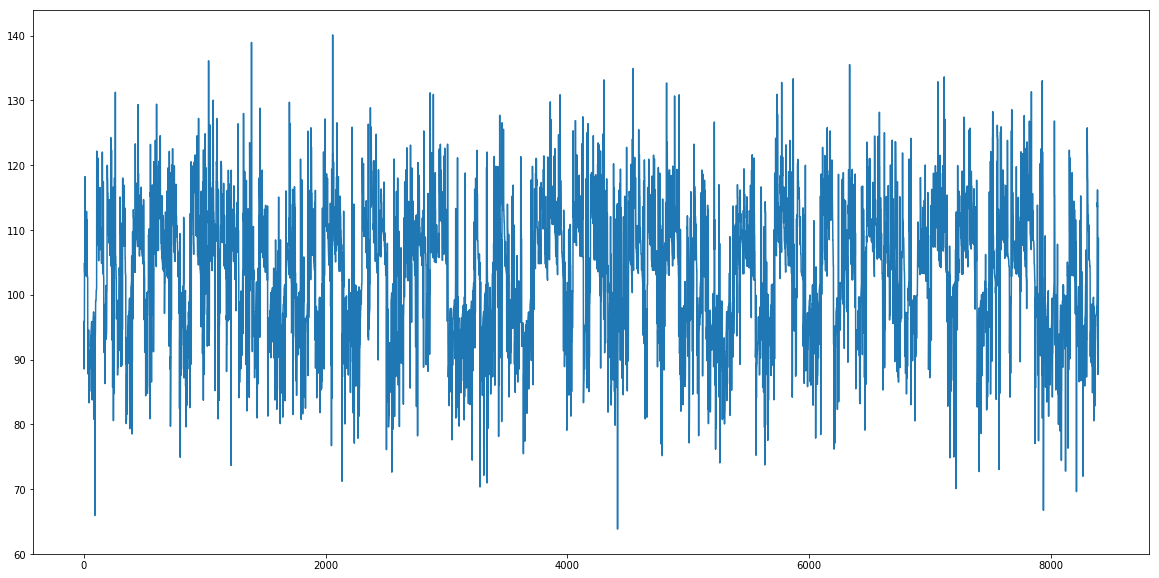

In [246]:
x = np.array(stock.trades)[:,0]
plt.figure(figsize=(20,10))
plt.plot(x)
plt.show()